In [1]:
%load_ext autoreload
%autoreload 2

# Results Analysis II: 

In this notebook we will calculate distributions for some of the outputs of our methods. Particularly, we want to explore the distributions of effective latitudes. 

In [2]:
import os
import dask
import joypy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path

# To use dask across the cluster
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [4]:
places = {
    'greenland': (71.75,360-42.5), 
    'chicago': (42,360-87.5),
    'hohhot': (41,111.75),
    'barent': (75,40.5),
    'pacific': (41.5,179.5)
}

## Testing with `jetstream` library

In [5]:
from jetstream.model.model import Model
from jetstream.model.analysis import Analysis

In [5]:
cluster = SLURMCluster()
print(cluster.job_script())
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p broadwl
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=19G
#SBATCH -t 00:10:00
#SBATCH --account=pi-moyer
#SBATCH --output=dask_worker.out
#SBATCH --error=dask_worker.err

/scratch/midway2/ivanhigueram/reanalysis_env/bin/python -m distributed.cli.dask_worker tcp://172.25.222.8:42008 --nthreads 4 --memory-limit 20.00GB --name name --nanny --death-timeout 60 --local-directory $SCRATCH --interface ib0



In [6]:
cluster.scale(20)

In [6]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40197")
client

Client Scheduler: tcp://127.0.0.1:40197 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB


In [11]:
model_obj = Analysis(
    path_to_files='/project2/geos39650/jet_stream/data/processed_winters/df_lat_20_1D.nc',
    #path_to_files='/project2/moyer/jetsream/cimp6_raw/CESM2-WACCM_ssp585_tas_daily.nc4',
    path_to_save_files='/project2/moyer/jetstream',
    season='DJF',
    temp_interval_size=1,
    subset_dict={'lat': 20, 'time': slice('2014-12-01', '2015-03-01')},
    chunks={'time': 10},
    rescale_longitude=True
)

In [64]:
t = model_obj.grid_area_xr
t = t.compute()

Cutting data using {'lat': 20, 'time': slice('2013-12-01', '2014-03-01', None)}


KeyboardInterrupt: 

In [11]:
end = model_obj.t_prime_calculation
end

Cutting data using {'lat': 20, 'time': slice('2010-12-01', '2011-03-01', None)}


,Array,Chunk
Bytes,290.30 MB,3.23 MB
Shape,"(90, 280, 1440)","(1, 280, 1440)"
Count,4514 Tasks,90 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,145.15 MB,1.61 MB
Shape,"(90, 280, 1440)","(1, 280, 1440)"
Count,3972 Tasks,90 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [12]:
# Load model xarray object
model_test = model_obj.data_array

# Add variables
model_test['area_grid'] = model_obj\
._calculate_area_from_latitude(model_test.lat)

# Take to dask.dataframe
array_ddf = model_test.\
to_dask_dataframe(dim_order=model_obj.DIMS)

# Add windows
model_test['max_temp'] = model_test.t2m.\
chunk({'time': 20}).\
rolling(time=14, min_periods=7).\
construct('tmp').\
max(dim=['lat', 'lon', 'tmp'])

model_test['min_temp'] = model_test.t2m.\
chunk({'time': 20}).\
rolling(time=14, min_periods=7).\
construct('tmp').\
min(dim=['lat', 'lon', 'tmp'])

# Convert to dask.dataframe
#array_ddf = model_test.\
#unify_chunks().\
#to_dask_dataframe(dim_order=model_obj.DIMS)
#array_ddf = model_test.data_array_dask_df()

Cutting data using {'lat': 20, 'time': slice('2014-12-01', '2015-03-01', None)}


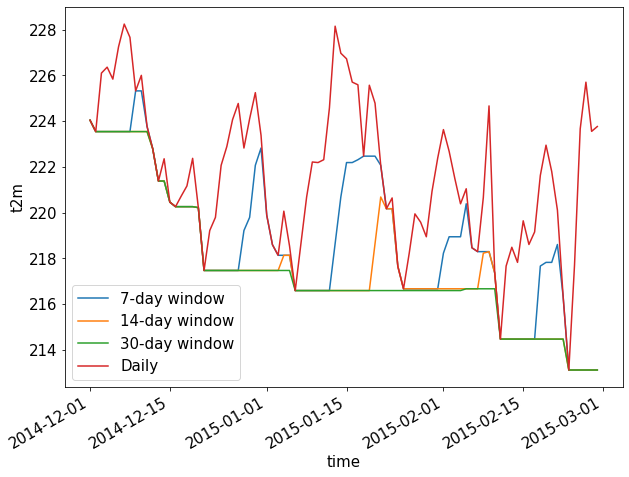

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
model_test.t2m.\
chunk({'time': 10}).\
rolling(time=7, min_periods=1).\
construct('tmp').\
min(dim=['lat', 'lon', 'tmp']).\
compute().plot.line(x='time', label='7-day window')

model_test.t2m.\
chunk({'time': 20}).\
rolling(time=14, min_periods=1).\
construct('tmp').\
min(dim=['lat', 'lon', 'tmp']).\
compute().plot.line(x='time', label='14-day window')

model_test.t2m.\
chunk({'time': 30}).\
rolling(time=30, min_periods=1).\
construct('tmp').\
min(dim=['lat', 'lon', 'tmp']).\
compute().plot.line(x='time', label='30-day window')

model_test.t2m.min(dim=['lat', 'lon']).plot(label='Daily')
ax.legend()

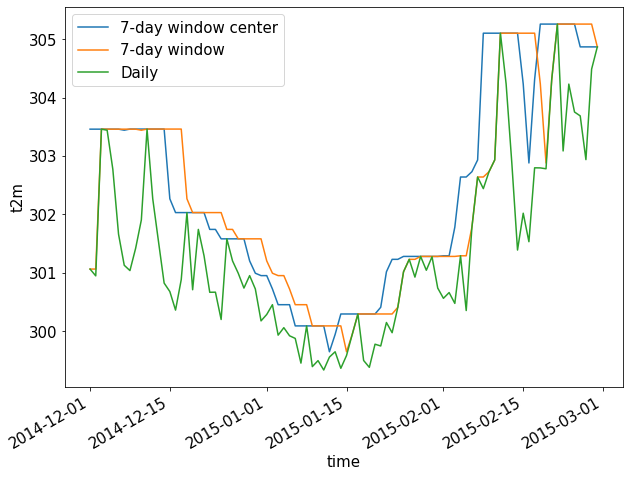

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))
model_test.t2m.\
chunk({'time': 10}).\
rolling(time=7, min_periods=7, center=True).\
construct('tmp').\
max(dim=['lat', 'lon', 'tmp']).\
compute().plot.line(x='time', label='7-day window center')

model_test.t2m.\
chunk({'time': 10}).\
rolling(time=7, min_periods=7, center=False).\
construct('tmp').\
max(dim=['lat', 'lon', 'tmp']).\
compute().plot.line(x='time', label='7-day window')

# model_test.t2m.\
# chunk({'time': 20}).\
# rolling(time=14, min_periods=7).\
# construct('tmp').\
# max(dim=['lat', 'lon', 'tmp']).\
# compute().plot.line(x='time', label='14-day window')

# model_test.t2m.\
# chunk({'time': 90}).\
# rolling(time=30, min_periods=7).\
# construct('tmp').\
# max(dim=['lat', 'lon', 'tmp']).\
# compute().plot.line(x='time', label='30-day window')

model_test.t2m.max(dim=['lat', 'lon']).plot(label='Daily')
ax.legend()

In [31]:
np.arange(1, 5, 1)

array([1, 2, 3, 4])

In [67]:
@dask.delayed
def create_bucket_window(array, start_window):
    
    print(
        f'''
        Label (time): {start_window}
        Array window shape: {array.shape}
        Array window dates: {array.time.values}
        '''
    )
    
    max_temp_window = array.max(dim=['lat', 'lon', 'time']).values
    min_temp_window = array.min(dim=['lat', 'lon', 'time']).values
    
    if not any(np.isnan([max_temp_window, min_temp_window])):
        bins_ = np.arange(min_temp_window, 
                          max_temp_window,
                          1)
        print(f'{label}: {bins_}')
        bins_labels_left = dict(enumerate(bins_, 1))
        buckets = np.digitize(array.isel(time=-1),
                              bins=bins_,
                              right=True
                             )
        buckets_temp = np.vectorize(bins_labels_left.get)(buckets)
        buckets_arr = xr.DataArray(buckets_temp,
                                   dims={
                                       'lat': array.lat.values,
                                       'lon': array.lon.values
                                   })
        buckets_arr = buckets_arr.assign_coords({'time': start_window})

        return buckets_arr

In [68]:
from tqdm import tqdm

r = model_test.t2m.\
chunk({'time': 5}).\
rolling(time=1,
        center=False,
        min_periods=1,
       )

lazy_results = []
for label, arr_window in r:
    bucket_array = create_bucket_window(
        array=arr_window,
        start_window=label
    )
    lazy_results.append(bucket_array)

In [69]:
lazy_exec = dask.compute(*lazy_results)
lazy_results_not_none = [r for r in lazy_exec if r is not None]

In [81]:
concat_array[]

<xarray.DataArray (lat: 280, lon: 1440)>
array([[266.03822327, 266.03822327, 266.03822327, ..., 266.03822327,
        266.03822327, 266.03822327],
       [266.03822327, 266.03822327, 266.03822327, ..., 266.03822327,
        266.03822327, 266.03822327],
       [265.03822327, 265.03822327, 265.03822327, ..., 265.03822327,
        265.03822327, 265.03822327],
       ...,
       [299.03822327, 299.03822327, 299.03822327, ..., 299.03822327,
        299.03822327, 299.03822327],
       [299.03822327, 299.03822327, 299.03822327, ..., 299.03822327,
        299.03822327, 299.03822327],
       [299.03822327, 299.03822327, 299.03822327, ..., 299.03822327,
        299.03822327, 299.03822327]])
Coordinates:
    time     datetime64[ns] 2014-12-01
Dimensions without coordinates: lat, lon

In [70]:
concat_array = xr.concat(lazy_results_not_none, dim='time')
model_test['temp_buckets'] = concat_array
model_test

<xarray.Dataset>
Dimensions:       (lat: 280, lon: 1440, time: 90)
Coordinates:
  * lat           (lat) float64 90.0 89.75 89.5 89.25 ... 21.0 20.75 20.5 20.25
  * lon           (lon) float64 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time          (time) datetime64[ns] 2014-12-01 2014-12-02 ... 2015-02-28
Data variables:
    t2m           (time, lat, lon) float32 dask.array<chunksize=(2, 280, 1440), meta=np.ndarray>
    area_grid     (lat) float32 -3.3741406e-05 3.368136 ... 723.02985 724.20245
    max_temp      (time) float32 dask.array<chunksize=(7,), meta=np.ndarray>
    min_temp      (time) float32 dask.array<chunksize=(7,), meta=np.ndarray>
    temp_buckets  (time, lat, lon) float64 266.0 266.0 266.0 ... 294.8 294.8

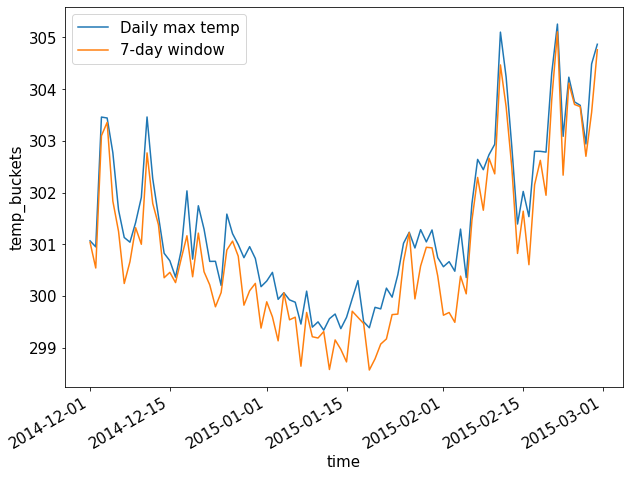

In [71]:
fig, ax = plt.subplots(figsize=(10, 7))
model_test.t2m.max(dim=['lat', 'lon']).plot(label='Daily max temp')
model_test.temp_buckets.max(dim=['lat', 'lon']).plot(label='7-day window')
ax.legend()

## Now try with `Dask`

In [357]:
array_ddf_indexed = array_ddf.set_index('time').repartition(2)

In [363]:
array_ddf_indexed.map_overlap(
lambda x: x.groupby(['lat', 'lon']).rolling('1d').t2m.max(),
    before=pd.Timedelta('1d'),
    after=0
).compute()

KeyboardInterrupt: 

In [196]:
def cut_day(df):
    
    bins_left = np.vectorize(lambda x: x.left)
    #temp_max=304
    #temp_min=218
    temp_max = np.ceil(df.t2m.max())
    temp_min = np.floor(df.t2m.min())
    offset = temp_max + 2
    
    bins = pd.cut(df.t2m, 
                  np.arange(temp_min, 
                            temp_max+offset,
                            1),
                  precision=0,
                  include_lowest=True
                 )
    
    df_ = pd.DataFrame({
        'time': df.time,
        'lat': df.lat,
        'lon': df.lon,
        't2m': df.t2m,
        'area_grid': df.area_grid,
        'temp_bucket': bins_left(bins)
    })
    
    return df_

In [53]:
from datetime import datetime
meta = pd.DataFrame({
    'time': pd.Series([], dtype='<M8[ns]'),
    'lat': pd.Series([], dtype='float'),
    'lon': pd.Series([], dtype='float'),
    't2m': pd.Series([], dtype='float'),
    'area_grid': pd.Series([], dtype='float'),
    'temp_bucket': pd.Series([], dtype='float'),
    
})

df_g = array_ddf.\
groupby('time').\
apply(cut_day,
      meta=meta
     )

#df_g = model_obj.data_array_dask_df

In [54]:
df_g.head()

,time,lat,lon,t2m,area_grid,temp_bucket
4435200,2010-12-12,90.0,-180.00,251.507812,-0.000034,251.0
4435201,2010-12-12,90.0,-179.75,251.507812,-0.000034,251.0
4435202,2010-12-12,90.0,-179.50,251.507812,-0.000034,251.0
4435203,2010-12-12,90.0,-179.25,251.507812,-0.000034,251.0
4435204,2010-12-12,90.0,-179.00,251.507812,-0.000034,251.0


In [133]:
model_test.unify_chunks().to_dask_dataframe().dropna()

,lat,lon,time,t2m,area_grid,max_temp,min_temp,temp_buckets
npartitions=15,,,,,,,,
0,float64,float64,datetime64[ns],float32,float32,float32,float32,float64
2332800,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
32659200,...,...,...,...,...,...,...,...
36287999,...,...,...,...,...,...,...,...


In [72]:
df_group = model_test.unify_chunks().to_dask_dataframe().\
dropna().\
groupby(['temp_buckets', 'time',]).\
area_grid.\
sum().\
compute()

In [73]:
df_group_sum = df_group.\
groupby(level=[1]).\
cumsum().\
reset_index()

df_group_sum['cdf_eff_lat_deg'] = df_group_sum\
 .groupby('time').\
area_grid.\
apply(model_obj._distributions_lat_eff)

df_group_sum

,temp_buckets,time,area_grid,cdf_eff_lat_deg
0,237.658142,2015-02-08,8.664720e+05,85.273033
1,238.658142,2015-02-08,1.875557e+06,83.043144
2,238.783249,2015-01-20,7.768372e+05,85.524330
3,238.930267,2015-01-30,8.851716e+05,85.222298
4,239.069519,2015-01-21,8.653162e+05,85.276192
...,...,...,...,...
7211,304.109009,2015-02-21,1.670967e+08,20.125336
7212,304.116089,2015-02-23,1.670974e+08,20.125158
7213,304.468445,2015-02-11,1.670974e+08,20.125179
7214,304.762009,2015-02-28,1.670975e+08,20.125151


<AxesSubplot:xlabel='temp_buckets'>

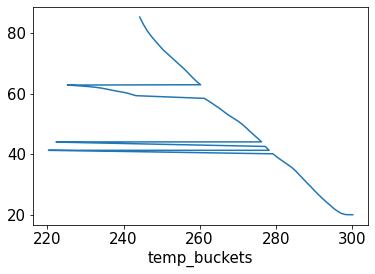

In [74]:
df_group_sum[df_group_sum.time == '2014-12-16'].\
set_index('temp_buckets').\
cdf_eff_lat_deg.\
plot()

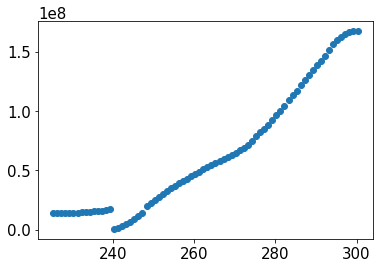

In [77]:
plt.scatter(
    df_group_sum[df_group_sum.time == '2014-12-30'].temp_buckets,
    df_group_sum[df_group_sum.time == '2014-12-30'].area_grid
)

In [59]:
xarr_test = df_group_sum.set_index(['time', 'temp_bucket']).\
to_xarray()
xarr_test = xarr_test.chunk({'time': 1})
xarr_test

,Array,Chunk
Bytes,32.40 kB,360 B
Shape,"(90, 90)","(1, 90)"
Count,91 Tasks,90 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,32.40 kB,360 B
Shape,"(90, 90)","(1, 90)"
Count,91 Tasks,90 Chunks
Type,float32,numpy.ndarray


In [60]:
xarr_test.sel(time='2010-12-20').area_grid.values

array([           nan,            nan, 2.19775806e+03,            nan,
       8.87700000e+03, 2.79829336e+04, 4.52659375e+04, 6.96091719e+04,
       1.13779164e+05, 1.83607672e+05, 2.52321719e+05, 3.38970219e+05,
       4.77625844e+05, 6.98292438e+05, 9.99939625e+05, 1.41291338e+06,
       1.83062838e+06, 2.29536475e+06, 2.73188900e+06, 3.16070725e+06,
       3.57630825e+06, 3.98354800e+06, 4.42774750e+06, 4.96634400e+06,
       5.56427600e+06, 6.38067900e+06, 7.26119100e+06, 8.11611600e+06,
       8.92280700e+06, 9.83200100e+06, 1.08285890e+07, 1.18657500e+07,
       1.28991730e+07, 1.44420690e+07, 1.61688670e+07, 1.78737580e+07,
       1.94878740e+07, 2.12100600e+07, 2.30439860e+07, 2.49969340e+07,
       2.70053060e+07, 2.89184700e+07, 3.08502860e+07, 3.26043400e+07,
       3.42897200e+07, 3.60545800e+07, 3.77503920e+07, 3.94741520e+07,
       4.14968880e+07, 4.34423120e+07, 4.55747240e+07, 4.81050360e+07,
       5.06573440e+07, 5.30928560e+07, 5.54943360e+07, 5.78159120e+07,
      

In [47]:
def interpolate_vectorized(eff_lat, lat, temp_bin_edges):
    
    print(f'dims:{eff_lat.shape}-{lat.shape}-{temp_bin_edges.shape}')
    xp = eff_lat[ ~ np.isnan(eff_lat)]
    fp = temp_bin_edges[ ~ np.isnan(eff_lat)]
    
    t_ref = np.interp(lat,
                     np.flip(xp),
                     np.flip(fp))
    
    return t_ref

In [434]:
xarr_test.cdf_eff_lat_deg

<xarray.DataArray 'cdf_eff_lat_deg' (time: 20, temp_bin: 87)>
dask.array<xarray-cdf_eff_lat_deg, shape=(20, 87), dtype=float32, chunksize=(1, 87), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1980-12-01 1980-12-02 ... 1980-12-20
  * temp_bin  (temp_bin) float64 217.0 218.0 219.0 220.0 ... 301.0 302.0 303.0

In [520]:
model_test.lat.values.shape

(280,)

In [531]:
t_ref = dask.array.apply_along_axis(interpolate_vectorized,
                                    1,
                                    arr=xarr_test.cdf_eff_lat_deg,
                                    dtype=xarr_test.temp_bin.dtype,
                                    shape=model_test.lat.values.shape,
                                    temp_bin_edges=xarr_test.temp_bin,
                                    lat=model_test.lat.values
                                    
                                   )
                   
t_ref_arr = xr.DataArray(t_ref,
             coords=[
                 ('time', xarr_test.time),
                 ('lat', model_test.lat.values)],
            )

In [628]:
t_ref_arr

<xarray.DataArray 'interpolate_vectorized-along-axis-fcfb59bb83c36f8e278773a347001935' (time: 20, lat: 280)>
dask.array<interpolate_vectorized-along-axis, shape=(20, 280), dtype=float64, chunksize=(1, 280), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 1980-12-20
  * lat      (lat) float32 20.25 20.5 20.75 21.0 21.25 ... 89.25 89.5 89.75 90.0

In [540]:
t_final = t_ref_arr.combine_first(model_test.t2m).to_dataset(name='tref')
t_final['t2m'] = model_test.t2m

In [543]:
t_final['t_prime'] = t_final['t2m'] - t_final['tref']

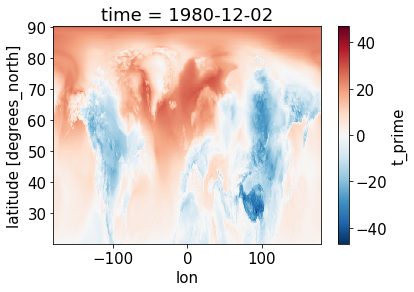

In [544]:
t_final.t_prime.isel(time=1).plot()

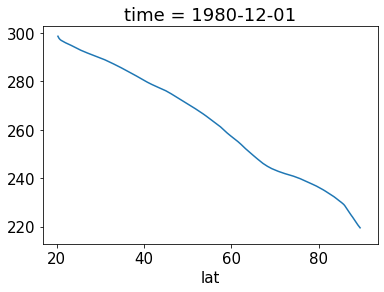

In [388]:
t_ref_arr.isel(time=0).plot()

In [627]:
t_ref

dask.array<interpolate_vectorized-along-axis, shape=(20, 280), dtype=float64, chunksize=(1, 280), chunktype=numpy.ndarray>

In [634]:
combine = t_ref_arr.combine_first(model_test.t2m).compute()
combine

<xarray.DataArray 'interpolate_vectorized-along-axis-fcfb59bb83c36f8e278773a347001935' (time: 20, lat: 280, lon: 1440)>
array([[[298.53445036, 298.53445036, 298.53445036, ..., 298.53445036,
         298.53445036, 298.53445036],
        [297.68504656, 297.68504656, 297.68504656, ..., 297.68504656,
         297.68504656, 297.68504656],
        [297.17374361, 297.17374361, 297.17374361, ..., 297.17374361,
         297.17374361, 297.17374361],
        ...,
        [219.51646956, 219.51646956, 219.51646956, ..., 219.51646956,
         219.51646956, 219.51646956],
        [218.59106071, 218.59106071, 218.59106071, ..., 218.59106071,
         218.59106071, 218.59106071],
        [217.        , 217.        , 217.        , ..., 217.        ,
         217.        , 217.        ]],

       [[298.57778302, 298.57778302, 298.57778302, ..., 298.57778302,
         298.57778302, 298.57778302],
        [297.74106463, 297.74106463, 297.74106463, ..., 297.74106463,
         297.74106463, 297.74106463],
        [297.30139243, 297.30139243, 297.30139243, ..., 297.30139243,
         297.30139243, 297.30139243],
...
        [221.53468591, 221.53468591, 221.53468591, ..., 221.53468591,
         221.53468591, 221.53468591],
        [221.        , 221.        , 221.        , ..., 221.        ,
         221.        , 221.        ],
        [221.        , 221.        , 221.        , ..., 221.        ,
         221.        , 221.        ]],

       [[297.75637665, 297.75637665, 297.75637665, ..., 297.75637665,
         297.75637665, 297.75637665],
        [297.00119265, 297.00119265, 297.00119265, ..., 297.00119265,
         297.00119265, 297.00119265],
        [296.47306009, 296.47306009, 296.47306009, ..., 296.47306009,
         296.47306009, 296.47306009],
        ...,
        [222.41891086, 222.41891086, 222.41891086, ..., 222.41891086,
         222.41891086, 222.41891086],
        [220.53775537, 220.53775537, 220.53775537, ..., 220.53775537,
         220.53775537, 220.53775537],
        [219.        , 219.        , 219.        , ..., 219.        ,
         219.        , 219.        ]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 1980-12-20
  * lat      (lat) float32 20.25 20.5 20.75 21.0 21.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 179.25 179.5 179.75

In [547]:
merge_df = df_g.reset_index(drop=True).\
merge(df_group_sum,
      on=['time', 'temp_bin']
     )

In [564]:
merge_df

,time,lat,lon,t2m,area_grid_x,temp_bin,area_grid_y,cdf_eff_lat_deg
npartitions=20,,,,,,,,
,datetime64[ns],float64,float64,float64,float64,float64,float32,float32
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [565]:
x = model_obj.dask_data_to_xarray(merge_df,
                                  var='cdf_eff_lat_deg')

In [571]:
x

<xarray.DataArray 'reshape-22e54dc169747a55846dc8d62e0c964c' (time: 20, lat: 280, lon: 1440)>
dask.array<reshape, shape=(20, 280, 1440), dtype=float32, chunksize=(3, 280, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-12-17 1980-12-11 ... 1980-12-04
  * lat      (lat) float32 20.25 20.5 20.75 21.0 21.25 ... 87.0 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.75 -179.5 -179.25 ... 9.0 9.75 9.5 9.25

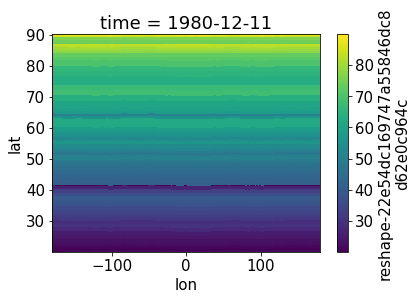

In [570]:
x.sortby(['lon', 'lat']).isel(time=1).plot()

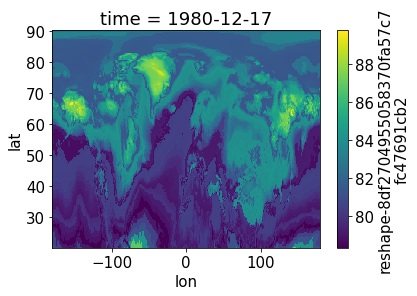

In [130]:
eff_lat = xr.DataArray(values_vars['cdf_eff_lat_deg'][1],
             coords=coords,
             dims=model_obj.DIMS
            )
eff_lat.isel(time=0).plot()

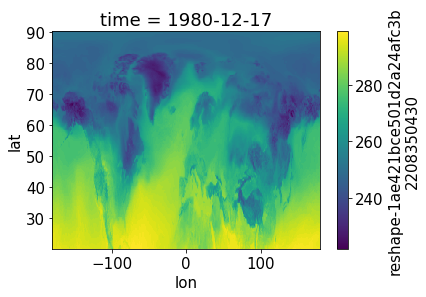

In [132]:
temp_bin_arr = xr.DataArray(values_vars['temp_bin'][1],
             coords=coords,
             dims=model_obj.DIMS
            )
temp_bin_arr.isel(time=0).plot()

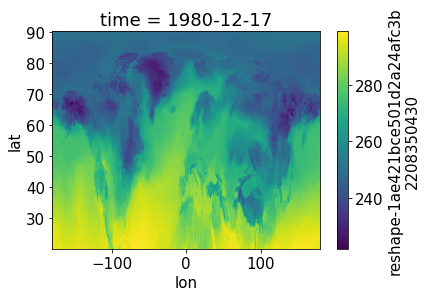

In [136]:
temp_bin_arr.interp(lat=np.flip(eff_lat.lat)).isel(time=0).plot()

In [37]:
dict(a=[1,2], b=[3,4]).keys()

dict_keys(['a', 'b'])

In [56]:
plt.scatter(
    t_area_group[t_area_group.time == '1980-12-20'].temp_bin,
    t_area_group[t_area_group.time == '1980-12-20'].area_grid
)

NameError: name 't_area_group' is not defined

In [10]:
places = {
    'greenland': (71.75,42.5), 
    'chicago': (42, 87.5),
    'hohhot': (41,111.75),
    'barent': (75,40.5),
    'pacific': (41.5,179.5)
    }
    
for model in models_paths:
    print(model)
    model_obj = Model(path_to_files=str(model),
                      path_to_save_files='/project2/moyer/jetstream',
                      season='DJF',
                      subset_dict={'lat': 20},
                      rescale_longitude=True)
    
    df_places = []
    for place, coords in places.items():
        print(place)
        model_obj.grid_area_df
        df_merge = model_obj.eff_lat_dist(
            latitude=coords[0],
            longitude=coords[1],
            season='DJF'
        ).compute()
        
        df_merge['place'] = place
        df_places.append(df_merge)
        
    df_complete = pd.concat(df_places)
    file_name = model.stem.split('-')[0]
    df_complete.to_csv(f'{file_name}_eff_lat.csv' ,index=False)

/project2/moyer/jetsream/cimp6_raw/MPI-ESM1-2-HR_ssp585_tas_daily.nc4
greenland
Cut data


Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /home/ivanhigueram/.local/lib/python3.7/site-packages/distributed/comm/core.py:279> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/ivanhigueram/.local/lib/python3.7/site-packages/distributed/comm/core.py", line 288, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/asyncio/tasks.py", line 435, in wait_for
    await waiter
concurrent.futures._base.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ivanhigueram/.local/lib/python3.7/site-packages/distributed/comm/core.py", line 295, in _
    raise CommClosedError()
distributed.comm.core.CommClosedError
Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /home/ivanhigueram/.local/lib/python3.7/site-pack

chicago


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


hohhot


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


barent


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


pacific


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


/project2/moyer/jetsream/cimp6_raw/CESM2-WACCM_ssp585_tas_daily.nc4
greenland


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/jetstream/model/model.py:31: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = xr_data.indexes['time'].to_datetimeindex()


Cut data


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


chicago


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


hohhot


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


barent


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


pacific


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


/project2/moyer/jetsream/cimp6_raw/UKESM1-0-LL_ssp585_tas_daily.nc4
greenland
Cut data


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


chicago


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


hohhot


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


barent


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


pacific


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


/project2/moyer/jetsream/cimp6_raw/IPSL-CM6A-LR_ssp585_tas_daily.nc4
greenland
Cut data


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


chicago


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


hohhot


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


barent


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


pacific
/project2/moyer/jetsream/cimp6_raw/GFDL-ESM4_ssp585_tas_daily.nc4
greenland


/scratch/midway2/ivanhigueram/reanalysis_env/lib/python3.7/site-packages/jetstream/model/model.py:31: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = xr_data.indexes['time'].to_datetimeindex()


Cut data


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


chicago


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


hohhot


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


barent


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


pacific


/home/ivanhigueram/.local/lib/python3.7/site-packages/dask/dataframe/core.py:3208: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('temp_bracket', 'category'))

  warnings.warn(meta_warning(meta))


In [25]:
import numpy as np
import pandas as pd
bins = np.arange(100.5, 345.0 + 2, 2)
bucket = pd.cut(np.arange(100.5, 345.0, 0.4), 
       bins=bins,
       include_lowest=True,
       right=True)
bucket[bucket.isna()]

[], Categories (123, interval[float64]): [(100.499, 102.5] < (102.5, 104.5] < (104.5, 106.5] < (106.5, 108.5] ... (338.5, 340.5] < (340.5, 342.5] < (342.5, 344.5] < (344.5, 346.5]]

In [9]:
model_obj = Model(path_to_files='/project2/moyer/jetsream/cimp6_raw/CESM2-WACCM_ssp585_tas_daily.nc4',
                  path_to_save_files='/project2/moyer/jetstream',
                  season='DJF',
                  subset_dict={'lat': 20},
                  rescale_longitude=True)

## Ploting joy-divisions

In [ ]:
def group_into_winters(dates): #untested
    year_arr = np.zeros(len(dates),dtype=int)
    y=0
    for date in dates:
        if date.month < 3:
            year_arr[y] = date.year - 1
        else:
            year_arr[y] = date.year
        y+=1
    return year_arr


def joy_div(data,
            time_key='year',
            time_var='time',
            data_key='t_prime',
            decade=False):
    ''' accepts a dataframe and make a joy division plot of successive distributions in data_key. 
     If decade=False, these distributions are calculated yearly. If True, they are calculated every 10 years'''
            
    data['year'] = group_into_winters(data[time_var])
    time_key='year'
    if decade:
        time_key='decade'
        data['decade'] = data.year.apply(lambda x: int(x)//10 * 10)
    data_filter = data.filter([time_key, data_key])
    
    labels=[y if y%5==0 else None for y in list(data[time_key].unique())]
    fig, axes = joypy.joyplot(data_filter, 
                          by=time_key,
                              labels=labels,
                              grid='y',
                              linewidth=1,
                          column=data_key,
                          fade=True,
                          figsize=(10, 10))
    plt.xlabel("Effective Latitude [degrees]")
    plt.ylabel("year")
    plt.show()
    plt.savefig('/home/ivanhigueram/public_html/joy_plt_prj.png')
    return data_filter


def overlayed_decades(data,
                      year,
                      ax,
                      var='t_prime',
                      clr='blue'):
    data_in_decade = data.loc[(data['decade']==year),var]
    
    sns.kdeplot(data_in_decade, 
                ax=ax,
                shade=True, 
                alpha=0.3, 
                Label=str(year)+'s',
                color=clr)
    
    quantiles = np.quantile(data_in_decade,[0.1,0.9])
    
    plt.axvline(quantiles[0],color=clr,linestyle='--',alpha=0.5)
    plt.axvline(quantiles[1],color=clr,linestyle='--',alpha=0.5)